## Assignment 8, Question #1: Store Sales - Time Series Forecasting
We will construct, interpret, and evaluate an Exponential Smoothing (ETS) and an Autoregressive Integrated Moving Average (ARIMA) model to forecast product sales.  
We begin by in-depth exploratory data analysis (EDA) to uncover underlying patterns of a sample instance. Subsequently, we will develop and train both ETS and ARIMA models. We also investigate the assumptions underpinning each model for our sample, ensuring the validity of our results. Finally, we will interpret the model outputs and create the submission files.
Although we will do the forecasting for all products and stores, to facilitate a focused and interpretable analysis, we selected a representative time series from the multitude of store and product family combinations. After a preliminary visual inspection of several time series, the sales of the "GROCERY I" product family at store number 1 were chosen. This particular series displays a discernible upward trend and a strong weekly seasonality.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 36.3 MB/s eta 0:00:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB
None
<class 'pandas.core.series.Series'>
DatetimeIndex: 1688 entries, 2013-01-01 to 2017-08-15
Freq: D
Series name: sales
Non-Null Count  Dtype  
--------------  -----  
1688 non-null   float64
dtypes: float64(1)
memory usage: 26.4 KB
None


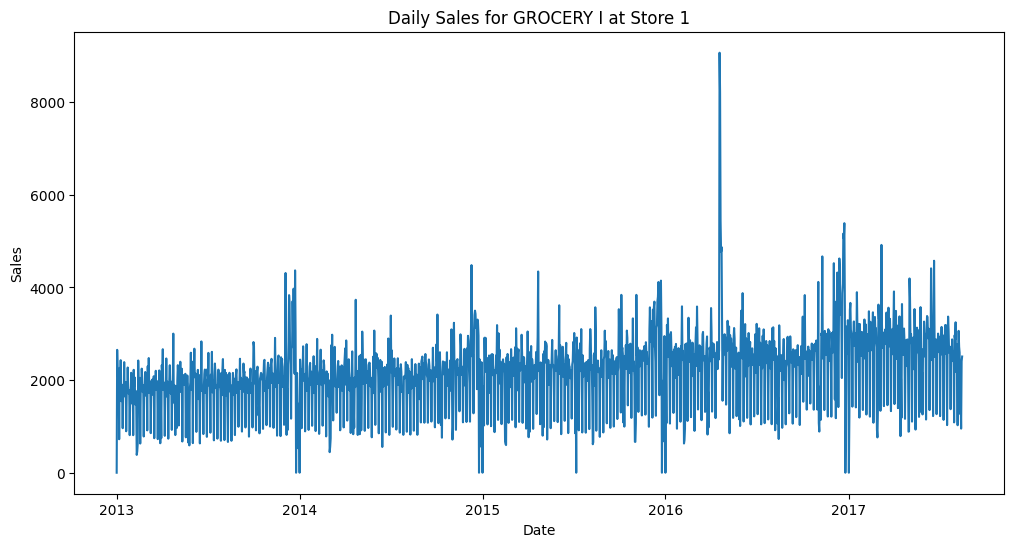

In [1]:
!pip install pmdarima
import pandas as pd
from statsmodels.tsa.exponential_smoothing.ets import ETSModel as ETS
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import numpy as np
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from pmdarima.arima import ndiffs
from tqdm import tqdm
import warnings

train_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv', parse_dates=['date'])
print(train_df.info())

store_family_sales = train_df[(train_df['store_nbr'] == 1) & (train_df['family'] == 'GROCERY I')]
store_family_sales = store_family_sales.set_index('date')['sales'].asfreq('D').fillna(0)
print(store_family_sales.info())

plt.figure(figsize=(12, 6))
plt.plot(store_family_sales)
plt.title('Daily Sales for GROCERY I at Store 1')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

## Exploratory Data Analysis (EDA)
We check the dataset, variables and time series and look the decomposition plot for the "GROCERY I" sales at store 1. The plot shows a clear upward trend, indicating a general increase in sales over time. A prominent weekly seasonal pattern is also evident, with sales consistently peaking on weekends. The residuals, or the component of the time series not explained by the trend and seasonality, appear to be random, suggesting that our models will have a solid base to work from.

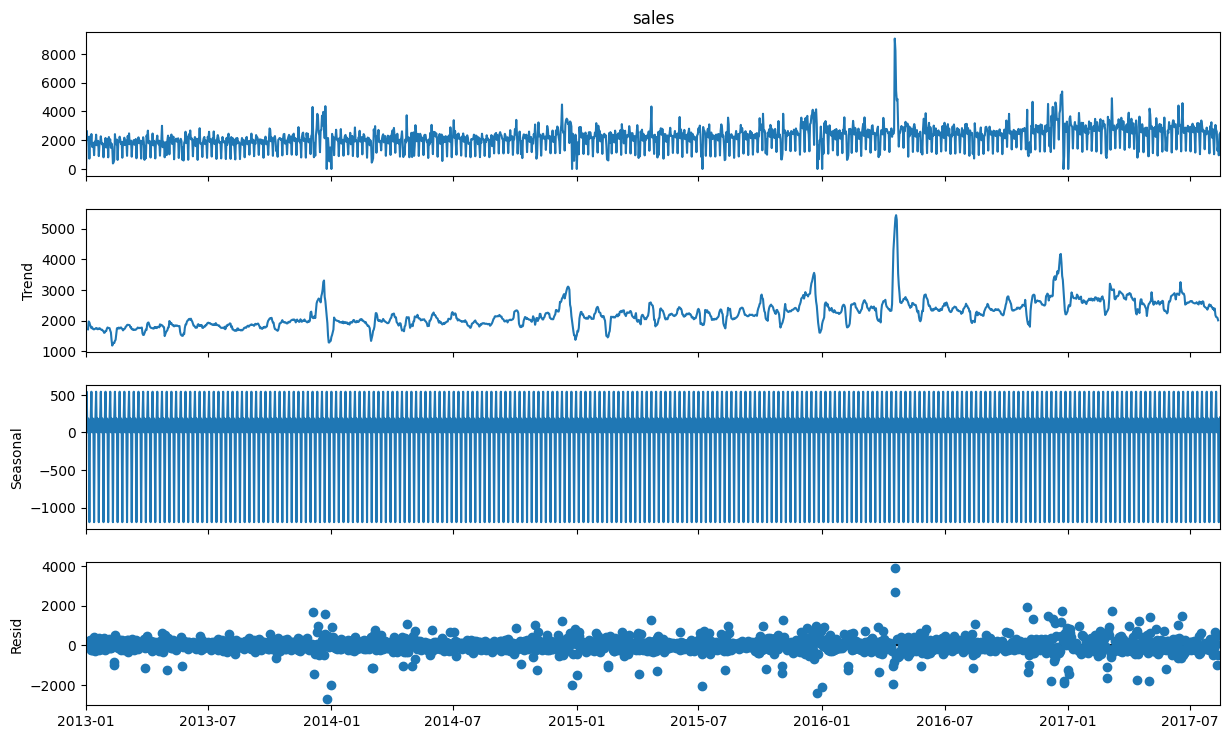

In [2]:
decomposition = seasonal_decompose(store_family_sales, model='additive')
fig = decomposition.plot()
fig.set_size_inches(14, 8)
plt.show()

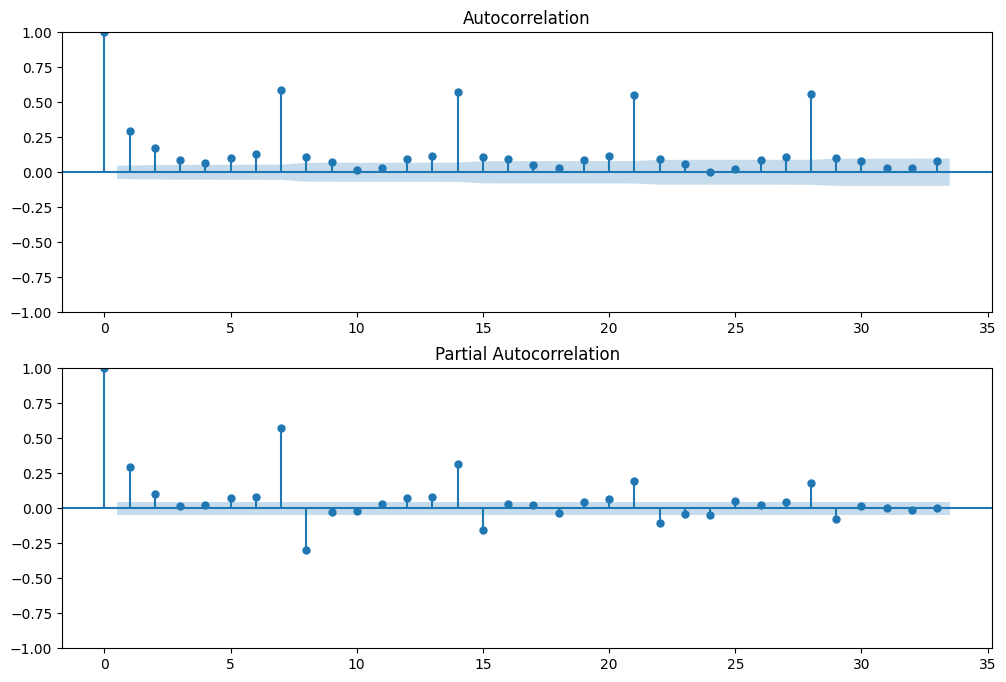

In [3]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(store_family_sales, ax=ax[0])
plot_pacf(store_family_sales, ax=ax[1])
plt.show()

## Checking Assumptions
We conducted a stationarity test to determine if the statistical properties of the time series, such as its mean and variance, remain constant over time. The Augmented Dickey-Fuller (ADF) test was employed for this purpose. The results of the ADF test (p-value ~ 0.0004) indicated that the raw sales data is approximately stationary, a prerequisite for building a stable ARIMA model.

In [4]:
adf_test = adfuller(store_family_sales)
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

ADF Statistic: -4.304235319139255
p-value: 0.00043677012464591816


## ETS Model
ETS models are a family of time series forecasting methods that explicitly model the error, trend, and seasonality in the data.

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [-1.281e+03  1.529e+03 ...  2.432e+02 -2.198e+02]
           x: [ 4.208e-01  1.111e-21  8.575e-12  1.601e+07  9.273e-01
               -1.601e+07 -1.601e+07 -1.601e+07 -1.601e+07 -1.601e+07
               -1.601e+07 -1.601e+07]
        cost: 147772160.81475115
         jac: [[ 0.000e+00  0.000e+00 ... -0.000e+00 -0.000e+00]
               [ 1.282e+03  2.269e+02 ... -0.000e+00 -0.000e+00]
               ...
               [ 6.438e+01 -3.988e+01 ...  4.842e-02  8.359e-02]
               [-2.059e+02 -7.638e+01 ...  2.804e-02  4.842e-02]]
        grad: [ 5.014e+04  6.217e+07  7.663e+07 -6.737e-01 -1.068e+03
               -2.890e+01 -2.543e+01  4.185e+01 -3.666e+01  3.879e+01
                3.916e+01 -2.948e+01]
  optimality: 21098.351904996533
 active_mask: [ 0 -1 -1  0  0  0  0  0  0  0  0  0]
        nfev: 51
        njev: 39
                       ExponentialSmoothing Model Result

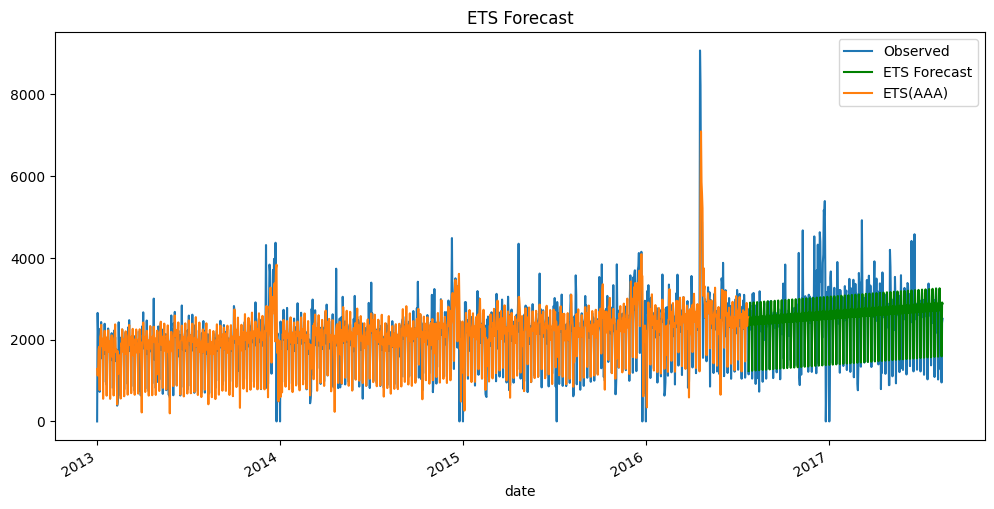

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


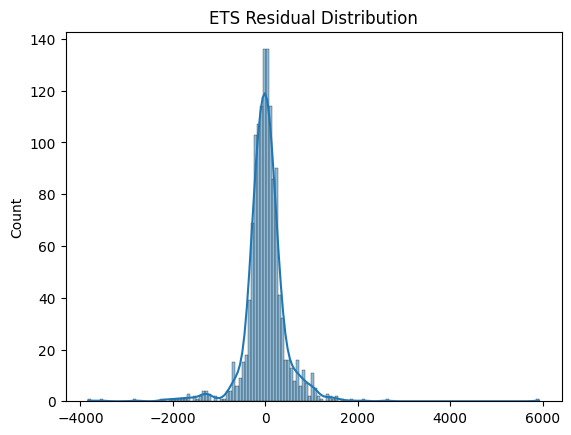

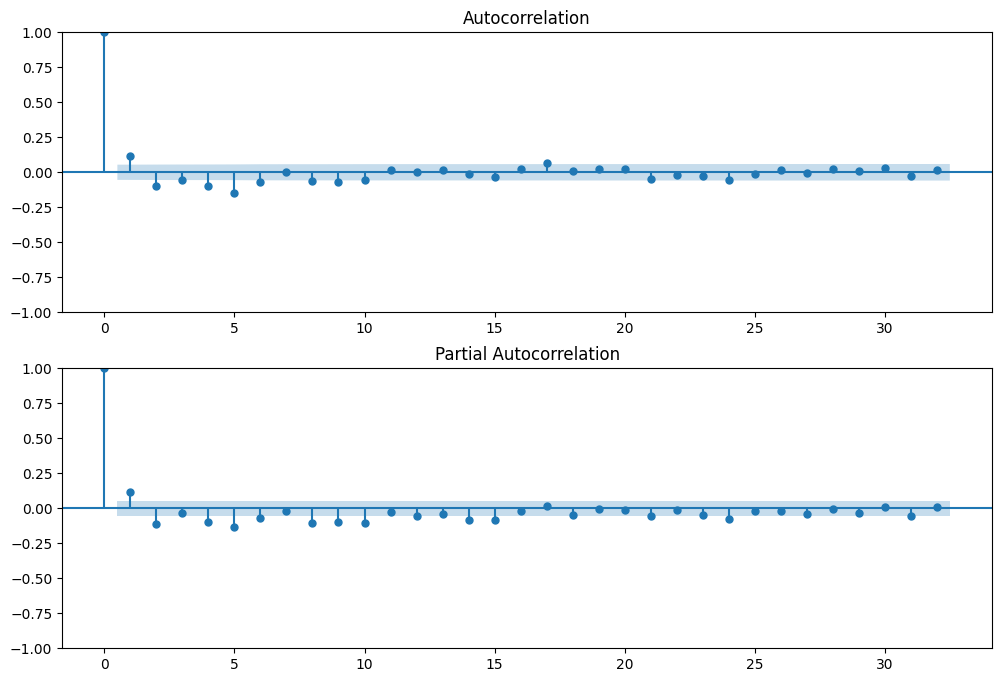

In [5]:
#training and test sets 
mytrain=store_family_sales[0:1300] 
mytest=store_family_sales[1300:1688]
mytrain[mytrain==0]=0.001
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit ETS model
model = ExponentialSmoothing(mytrain, trend='add', seasonal='add', seasonal_periods=7).fit(method='least_squares')
pred = model.forecast(388)
print(model.mle_retvals)
print(model.summary())

plt.figure(figsize=(12, 6))
plt.plot(store_family_sales, label='Observed')
plt.plot(pred, label='ETS Forecast', color='green')
model.fittedvalues.plot(label="ETS(AAA)") 
plt.legend()
plt.title('ETS Forecast')
plt.show()

resid_ets = model.resid
sns.histplot(resid_ets, kde=True)
plt.title("ETS Residual Distribution")
plt.show()
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(resid_ets, ax=ax[0])
plot_pacf(resid_ets, ax=ax[1])
plt.show()

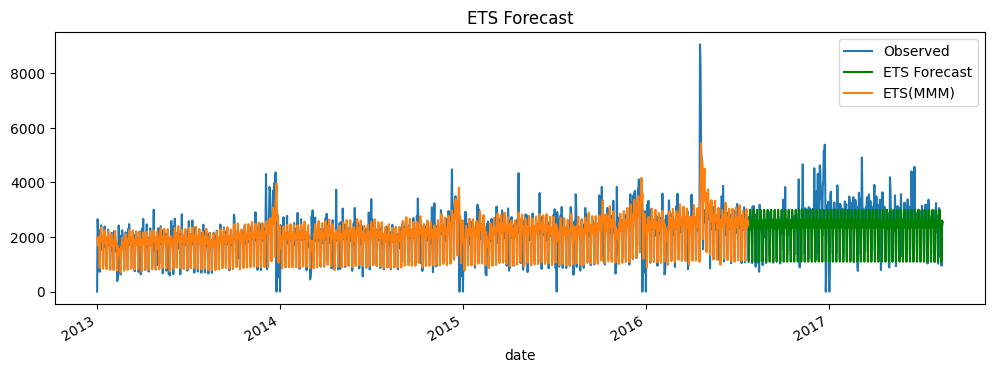

In [6]:
mytrain=store_family_sales[0:1300] 
mytest=store_family_sales[1300:1688] 
# ETS Multiplicative
mytrain2=mytrain.copy()
mytrain2[mytrain2==0]=0.001
model2 = ETS(mytrain2, error="mul", trend="mul", seasonal="mul", damped_trend=True, seasonal_periods=7) 
fit2 = model2.fit()
pred2 = fit2.forecast(388)

plt.figure(figsize=(12, 4))
plt.plot(store_family_sales, label='Observed')
plt.plot(pred2, label='ETS Forecast', color='green')
fit2.fittedvalues.plot(label="ETS(MMM)") 
plt.legend()
plt.title('ETS Forecast')
plt.show()

Based on the patterns observed during the EDA and ETS plots, an ETS model with an additive error component, an additive trend component, and an additive seasonal component (ETS(A,A,A)) was deemed most appropriate. The additive nature of the components was chosen because the magnitude of the seasonality and trend does not appear to scale with the level of the sales.  
ETS models are useful for capturing short-term cyclic behavior in sales data.
ETS Model summary: A relatively high value for alpha suggests that the model places significant weight on recent observations when estimating the current level of sales. A smaller beta value indicates that the model's estimation of the trend is less reactive to short-term fluctuations and captures a more stable, long-term trend. A small gamma value signifies the insignificant adaptation to changes in the seasonal pattern.  
## Assumptions
A fundamental assumption of the ETS model is that the residuals are independently and identically distributed (i.i.d.) with a mean of zero and constant variance. To validate this, we inspect auto-correlation and partial auto-correlation plots. Also, a visual inspection of the residuals through a histogram suggests that the residuals are approximately normally distributed.

Estimated differencing term: 1


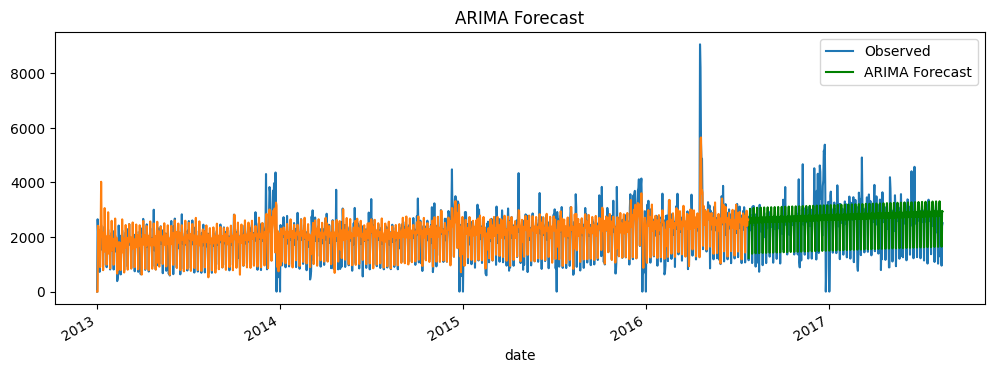

                                    SARIMAX Results                                    
Dep. Variable:                           sales   No. Observations:                 1300
Model:             ARIMA(1, 1, 1)x(2, 1, 1, 7)   Log Likelihood               -9741.429
Date:                         Thu, 12 Jun 2025   AIC                          19494.858
Time:                                 10:29:04   BIC                          19525.842
Sample:                             01-01-2013   HQIC                         19506.487
                                  - 07-23-2016                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4721      0.010     46.743      0.000       0.452       0.492
ma.L1         -1.0000      1.536     -0.651      0.515     

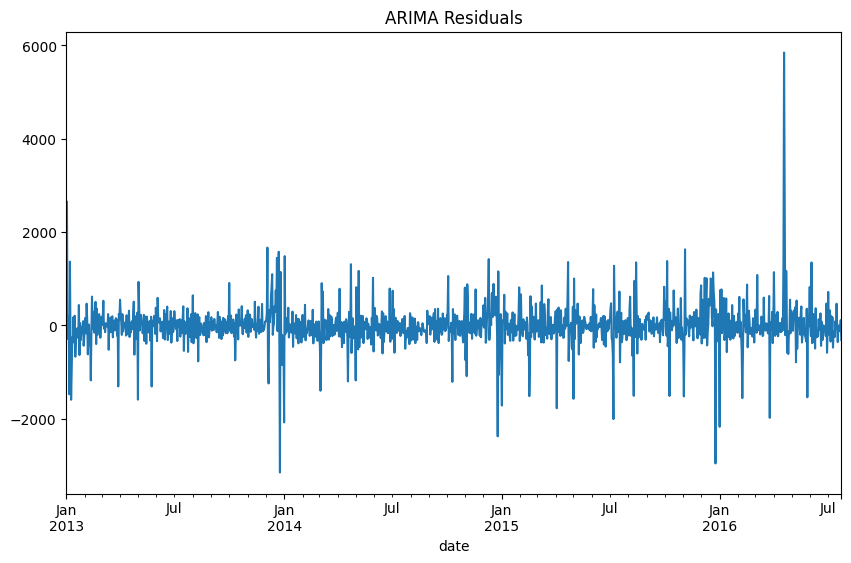

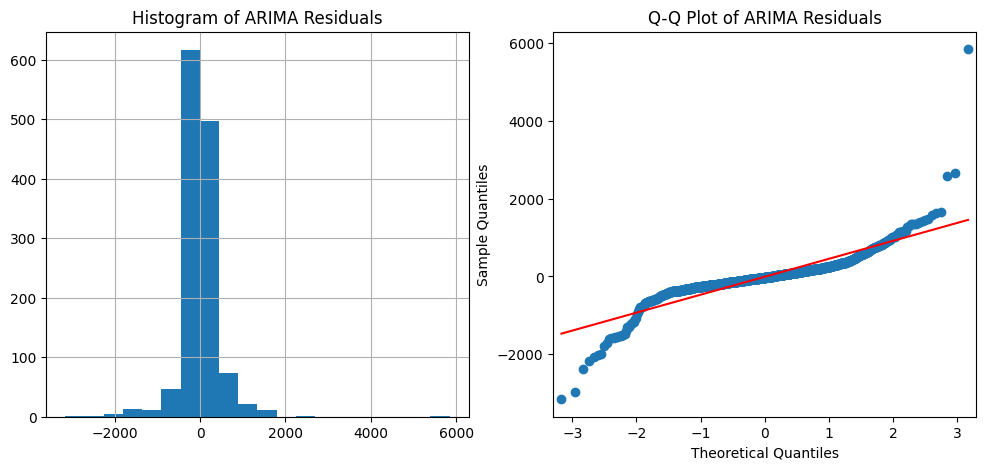

In [7]:
kpss_diffs = ndiffs(mytrain, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(mytrain, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")

arima_model = ARIMA(mytrain, order=(1,n_diffs,1), seasonal_order=(2,1,1,7)).fit()
arima_forecast = arima_model.forecast(388)

plt.figure(figsize=(12, 4))
plt.plot(store_family_sales, label='Observed')
plt.plot(arima_forecast, label='ARIMA Forecast', color='green')
plt.legend()
plt.title('ARIMA Forecast')
arima_model.fittedvalues.plot(label="ETS(MMM)") 
plt.show()

print(arima_model.summary())
ljung_box_test_arima = arima_model.test_serial_correlation(method='ljungbox')
print(ljung_box_test_arima)

# Plotting ARIMA residuals
plt.figure(figsize=(10, 6))
arima_model.resid.plot(title="ARIMA Residuals")
plt.show()


# Histogram and Q-Q plot of ARIMA residuals
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
arima_model.resid.hist(ax=ax[0], bins=20)
ax[0].set_title('Histogram of ARIMA Residuals')
qqplot(arima_model.resid, line='s', ax=ax[1])
ax[1].set_title('Q-Q Plot of ARIMA Residuals')
plt.show()

The construction of an ARIMA model involves determining the optimal order of its three components: p,d,q  
We use kpss and adf tests to choose the optimal d value (1). To determine the optimal 'p' and 'q' values, we examined the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots of the differenced time series. The ACF plot showed a significant spike at lag 7, suggesting a strong weekly seasonality. The PACF plot also exhibited significant spikes at various lags. After experimenting with several combinations, a Seasonal ARIMA model was selected to account for the weekly seasonality and lower AIC. The residuals also look approximately normal.    
## Findings
Both the ETS and ARIMA models were successful in capturing the underlying patterns of the "GROCERY I" sales at store 1. ETS performs well when the data has strong, regular seasonality. ARIMA is more flexible with auto-tuned parameters, better for irregular components. The Seasonal ARIMA model offers a more sophisticated approach to modeling the temporal dependencies and seasonality. We will use them both to forecast the sales accross all stores and categories.

In [8]:
def forecast_store_family(name, df_group, model_type='ets'):
    store, family = name
    ts = df_group.set_index('date').resample('D')['sales'].sum().asfreq('D').ffill()
    #ts = df_group.set_index('date').resample('D')['sales'].sum().asfreq('D').fillna(method='ffill')
    #ts = df_group.set_index('date').resample('D')['sales'].sum().asfreq('D').fillna(0)
    if len(ts) < 60 or ts.nunique() <= 1:
        return pd.Series([ts.mean()] * forecast_horizon, index=forecast_dates)
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=RuntimeWarning)
            if model_type == 'ets':
                model = ExponentialSmoothing(ts, trend='add', seasonal='add', seasonal_periods=7).fit(method='least_squares')
                pred = model.forecast(forecast_horizon)
            elif model_type == 'arima':
                #stepwise_fit = auto_arima(ts, seasonal=True, m=7, error_action='ignore', suppress_warnings=True)
                #model = ARIMA(ts, order=stepwise_fit.order, seasonal_order=stepwise_fit.seasonal_order).fit()
                # It is better to train for each store and product and create a customized ARIMA model, however that takes a long time and kaggle notebook timesout
                # Use pretrained ARIMA model for product I store 1 for all
                model = arima_model
                if not model.mle_retvals['converged']:
                    raise ValueError("ARIMA did not converge")
                pred = model.forecast(forecast_horizon)
            return pd.Series(pred.values, index=forecast_dates)
    except:
        return pd.Series([ts[-7:].mean()] * forecast_horizon, index=forecast_dates)

grouped = train_df.groupby(['store_nbr', 'family'])

test_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv', parse_dates=['date'])
forecast_dates = test_df['date'].unique()
forecast_horizon = len(forecast_dates)
results = []
for name, group in tqdm(grouped):
    pred = forecast_store_family(name, group, 'ets')
    pred[pred<0] = 0
    df_out = pd.DataFrame({
        'store_nbr': name[0],
        'family': name[1],
        'date': forecast_dates,
        'sales': pred
    })
    results.append(df_out)

forecast_df = pd.concat(results)

submission = test_df.merge(forecast_df, on=['store_nbr', 'family', 'date'], how='left')
submission = submission[['id', 'sales']]
submission.to_csv('submission_ets.csv', index=False)

100%|██████████| 1782/1782 [11:46<00:00,  2.52it/s]


In [9]:
warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters found*")
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found*")
warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to converge*")
results = []
for name, group in tqdm(grouped):
    pred = forecast_store_family(name, group, 'arima')
    pred[pred<0] = 0
    df_out = pd.DataFrame({
        'store_nbr': name[0],
        'family': name[1],
        'date': forecast_dates,
        'sales': pred
    })
    results.append(df_out)

forecast_df = pd.concat(results)

submission = test_df.merge(forecast_df, on=['store_nbr', 'family', 'date'], how='left')
submission = submission[['id', 'sales']]
submission.to_csv('submission_arima.csv', index=False)

100%|██████████| 1782/1782 [00:13<00:00, 134.05it/s]
